In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

____
### Predicciones

In [89]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.model_selection import train_test_split
# from xgboost import plot_importance, plot_tree

from src.common.utils import get_date_for_timestamp_file, get_metrics
from src.features.build_features import add_date_features
from src.visualization.visualize import plot_importance_reg

Para las predicciones se realizaron pruebas con dos algoritmos RandomForest y Xgboost en sus versiones de regresión. 

En particular, RandomForest es un algoritmo de bagging y Xgboost es un algoritmo de boosting. La forma de trabajar de ambos algoritmos es entrenar árboles débiles, e ir concatenando la respuesta para generar un estimador más potente. Se diferencian según la forma en que genera los estimadores y luego pondera los datos para dar la predicción.

![alt text](./img/bagging_vs_boosting.png)

Las métricas que utilizamos fueron 3:
- "explained_variance_score": el mejor valor es 1 y valores chicos son malos. Relacionada con R2
- "mae": El mejor valor es 0 y es robusto a valores fuera de rango. Corresponde al promedio de error de la suma de todas las muestras.
- "r2": Computa el coeficiente de determinación, el mejor valor es 1 y valores bajos son malos (pueden ser negativos). Proporciona la calidad del entrenamiento, por lo tanto, una medida de qué tan bien es probable que el modelo prediga muestras invisibles, a través de la proporción de la varianza explicada.


In [4]:
df_ventas = pd.read_parquet('../data/interim/01-ventas.parquet')

In [7]:
df_ventas = df_ventas[["id_pos","year","month","unidades"]]

In [18]:
def add_unidades_before(df):
    df.unidades = df.unidades.astype('int')
    df.loc[:,"unidades_anterior"] = df.unidades.shift(1).fillna(-1).astype('int')
    df.loc[:,"unidades_12"] = df.unidades.shift(12).fillna(-1).astype('int')
    df.loc[:,"unidades_13"] = df.unidades.shift(13).fillna(-1).astype('int')
    df.loc[:,"unidades_24"] = df.unidades.shift(24).fillna(-1).astype('int')
    df.loc[:,"unidades_25"] = df.unidades.shift(25).fillna(-1).astype('int')
    return df
    

In [26]:
df_ventas = (
    df_ventas.sort_values(['year','month'])
    .groupby("id_pos")
    .apply(add_unidades_before)
)

In [107]:
cols_prediction = [
    "id_pos", 
    "year", 
    "month", 
    "unidades_anterior", 
#     "unidades_12", 
#     "unidades_13", 
    "unidades_24",
    "unidades_25"
]

In [108]:
X = df_ventas.loc[:, cols_prediction]

y = df_ventas.loc[:,['unidades']]

In [109]:
reg = RandomForestRegressor(
    n_estimators=250,
    max_depth=8
)

In [110]:
reg.fit(X, y.values.reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [111]:
reg_xgb = xgb.XGBRFRegressor(
    n_estimators=250,
    max_depth=8,
    missing=-1,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    eval_metric='mae'
)

In [112]:
reg_xgb.fit(X, y.values.reshape(-1))

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, early_stopping_rounds=50, eval_metric='mae',
               gamma=0, learning_rate=1, max_delta_step=0, max_depth=8,
               min_child_weight=1, missing=-1, n_estimators=250, n_jobs=1,
               nthread=None, objective='reg:squarederror', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1)

In [113]:
get_metrics(y, np.round(reg.predict(X)))

{'explained_variance_score': 0.7390015610864822,
 'mae': 0.8307794289571055,
 'r2': 0.7390015218877473}

In [114]:
get_metrics(y, np.round(reg_xgb.predict(X)))

{'explained_variance_score': 0.7272342024590239,
 'mae': 0.8460112569451977,
 'r2': 0.7272330301540372}

Visualizamos la feature_importance para saber que seleccionó el modelo, y podemos observar que xgboost sobreajusta mucho con la característica "month" y no le da tanta importancia a las demás. En cambio, RandomForest si. Podemos verificar que unidades-24 y unidades-25 prácticamente no tuvo importancia en el modelo a la hora de la predicción.

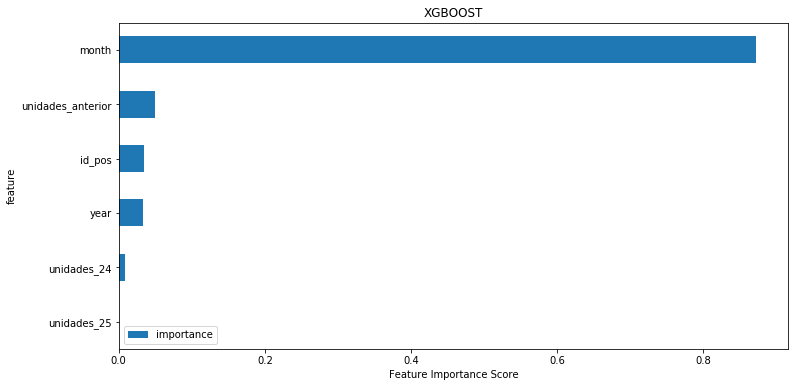

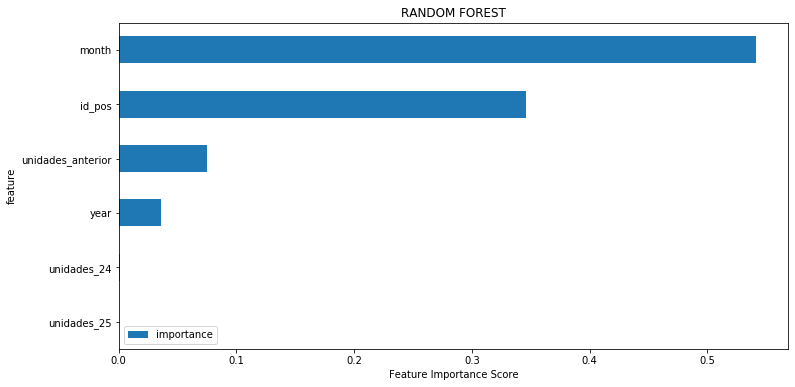

In [115]:
plot_importance_reg(reg_xgb, cols_prediction, "XGBOOST")
plot_importance_reg(reg, cols_prediction, "RANDOM FOREST")

## Verificando nuestro modelo
Utilizamos los modelos para realizar las predicción.
En primera instancia, mostramos los valores que predice el modelo para toda la serie en donde tenemos los datos. 

Podemos observar que las predicciones fueron aproximadamente similares para ambos casos. 

In [116]:
df_graph = X[["id_pos", "year", "month"]].copy()
df_graph.loc[:, "unidades"] = y
df_graph.loc[:, "pred"] = np.round(reg.predict(X))

df_graph = df_graph.groupby(["year","month"])[["unidades","pred"]].sum()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd338032ac8>,
      dtype=object)

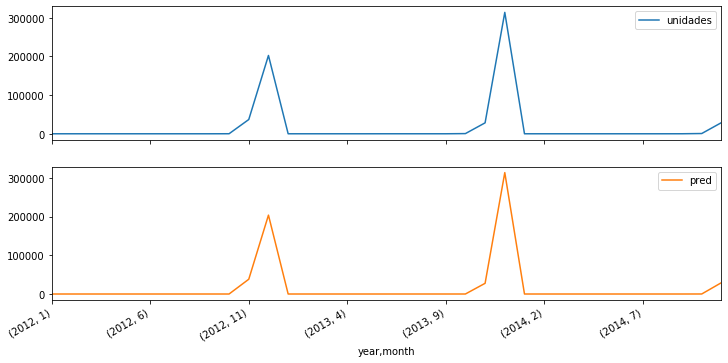

In [117]:
df_graph.plot.line(figsize=(12,6), subplots=True)

### Predicción
Generamos nuestra predicción en X_predict para todos los id_pos para el mes de diciembre

In [118]:
def assign_unidades_anteriores(ventas_totales, year, month):
    return (
        ventas_totales
        .set_index('id_pos')
        [lambda df: (df.year == year) & (df.month==month)]
        .unidades
        .reindex(ventas_totales.id_pos.unique())
        .fillna(0) # o -1?
    )


In [119]:
dt = get_date_for_timestamp_file()

In [120]:
X_predict = pd.DataFrame({'id_pos': X.id_pos.unique()})
X_predict.loc[:,'fecha'] = pd.date_range('12/1/2014', periods=1, freq='M')
add_date_features(X_predict)

X_predict = X_predict.loc[:,["id_pos", "year", "month"]]

X_predict.loc[:,"unidades_anterior"] = assign_unidades_anteriores(df_ventas, 2014, 11)
# X_predict.loc[:,"unidades_12"] = assign_unidades_anteriores(df_ventas, 2013, 12)
# X_predict.loc[:,"unidades_13"] = assign_unidades_anteriores(df_ventas, 2013, 11)
X_predict.loc[:,"unidades_24"] = assign_unidades_anteriores(df_ventas, 2012, 12)
X_predict.loc[:,"unidades_25"] = assign_unidades_anteriores(df_ventas, 2012, 11)
X_predict.fillna(-1, inplace=True)

In [121]:
X_predict.loc[:,"pred"] = np.round(reg.predict(X_predict))

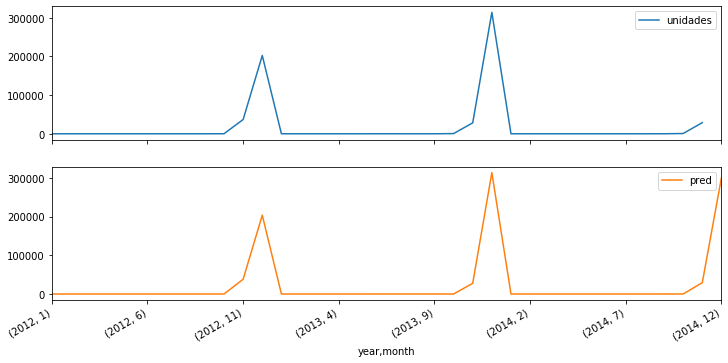

In [122]:
(
    df_graph
    .append(X_predict.groupby(['year','month'])[["pred"]].sum(), sort=False)
    .plot.line(subplots=True, figsize=(12,6))
)

plt.savefig('../reports/figures/05-01-predicción-{}.svg'.format(dt))

Guardamos la respuesta en un archivo

Me quedo con todos los id_pos del archivo de respuestas, ya que algunos no tienen ventas, a ellos le agregó unidades "0". Los mismos, deben encontrarse ordenados igual que el archivo de ejemplo. 

In [123]:
df_pos = pd.read_parquet('../data/interim/02-pos.parquet')
df_pos = pd.DataFrame(df_pos.reset_index().id_pos.unique(),columns=["id_pos"])

In [124]:
(
    df_pos
    .merge(X_predict[["id_pos","pred"]], how="left")
    .fillna(0)[["id_pos","pred"]]
    .to_csv('../data/processed/rta-{}.csv'.format(dt), index=False, header=False)
)

In [126]:
df_ventas.to_parquet('../data/interim/05-ventas.parquet')

Guardamos el modelo para que pueda usarse luego.

In [106]:
import pickle
pickle.dump(reg, open('../models/model_{}'.format(dt), 'wb'))